In [20]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

In [21]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [22]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [23]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [24]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950,shift_pct=0 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])



18

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [25]:
import numpy as np

# --- Paramètres ---
train_pct = 0.7
featveclen = len(myds["fire", 0])  # taille d’un vecteur de caractéristiques
nitems = len(myds)
naudio = dataset.naudio  # dict: nombre d’audios par classe
nclass = dataset.nclass  # nombre total de classes
data_aug_factor = 1
classnames = list(naudio.keys())  # assure que classnames est bien défini
naudio_sum = sum(naudio.values())  # total d’échantillons toutes classes confondues

# ID des classes (répétés selon le nombre d’audios par classe)
class_ids_aug = np.concatenate([
    np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames
])

# --- Préparation des offsets cumulatifs pour les index globaux ---
offsets = {}
current_offset = 0
for cname in classnames:
    offsets[cname] = current_offset
    current_offset += naudio[cname]

# --- Allocation de la matrice X ---
X = np.zeros((data_aug_factor * naudio_sum, featveclen))

# --- Remplissage de X avec les vecteurs de caractéristiques ---
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]

            global_idx = s * naudio_sum + offsets[classname] + idx
            X[global_idx, :] = featvec

            # Debug
            if global_idx == 225:
                print("ici------------------------------------------------")
            print(f"Index: {global_idx}, Class Name: {classname}")

# --- Étiquettes ---
y = class_ids_aug.copy()
classnames = np.unique(y)

np.save(fm_dir + "feature_matrix_2D.npy", X)
np.save(fm_dir + "labels_2D.npy", y)

# --- Affichage de résumé ---
print("-" * 20)
for idx, elem in enumerate(X):
    mean_value = np.mean(elem)
    class_name = y[idx]
    print(f"Index: {idx}, Class Name: {class_name}, Mean Value: {mean_value}")
    
X = np.load(fm_dir + "feature_matrix_2D.npy")
y = np.load(fm_dir + "labels_2D.npy")

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

# Statistiques par classe
unique_classes, class_counts = np.unique(y, return_counts=True)
# for classname, count in zip(unique_classes, class_counts):
#     print(f"Class '{classname}': {count} samples")
    
# for class_name in classnames:
   

#     y_aug_class_indices = np.where(y == class_name)[0]
#     print(f"Indices where y_aug == {class_name}:", y_aug_class_indices[:5])  # First 5 indices

#     # Plot the mel spectrograms for every sound of the current class
#     for idx in y_aug_class_indices:
#         plt.figure(figsize=(2, 1))
#         plt.imshow(X[idx].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {class_name} at index {idx}")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()
#         plt.show()


Index: 0, Class Name: chainsaw
Index: 1, Class Name: chainsaw
Index: 2, Class Name: chainsaw
Index: 3, Class Name: chainsaw
Index: 4, Class Name: chainsaw
Index: 5, Class Name: chainsaw
Index: 6, Class Name: chainsaw
Index: 7, Class Name: chainsaw
Index: 8, Class Name: chainsaw
Index: 9, Class Name: chainsaw
Index: 10, Class Name: chainsaw
Index: 11, Class Name: chainsaw
Index: 12, Class Name: chainsaw
Index: 13, Class Name: chainsaw
Index: 14, Class Name: chainsaw
Index: 15, Class Name: chainsaw
Index: 16, Class Name: chainsaw
Index: 17, Class Name: chainsaw
Index: 18, Class Name: chainsaw
Index: 19, Class Name: chainsaw
Index: 20, Class Name: chainsaw
Index: 21, Class Name: chainsaw
Index: 22, Class Name: chainsaw
Index: 23, Class Name: chainsaw
Index: 24, Class Name: chainsaw
Index: 25, Class Name: chainsaw
Index: 26, Class Name: chainsaw
Index: 27, Class Name: chainsaw
Index: 28, Class Name: chainsaw
Index: 29, Class Name: chainsaw
Index: 30, Class Name: chainsaw
Index: 31, Class N

In [26]:
# # Plot the spectrograms for zero mean indices

# for classname in classnames:
#     all_indices =np.where(y == classname)[0]
    
#     for idx in all_indices:
#         plt.figure(figsize=(8, 6))
#         plt.imshow(X[idx].reshape(20,20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {classname} at index {idx} (Zero Mean)")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()  # Invert the y-axis for standard spectrogram orientation
#         plt.show()

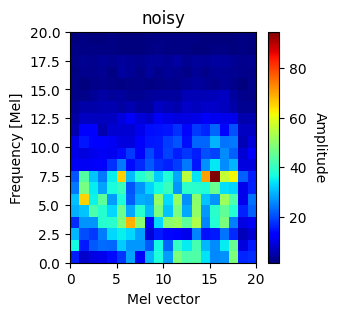

In [31]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# # Initialize the feature matrix and labels for multiple shift_pct values
# X_aug_list = []
# y_aug_list = []

# naudio_sum = sum(naudio.values())  # total number of audio samples (non-augmented)

# for shift_pct in tqdm([1, 1, 1, 1, 1, 1], desc="Processing shift_pct values"):
#     # Create a Feature_vector_DS for the current shift_pct
#     myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
#     myds_shifted.mod_data_aug(["noise", "echo", "background_noise"])

#     # Initialize feature matrix and labels for the current shift_pct
#     X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
#     y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)

#     # Precompute offsets per class
#     offsets = {}
#     current_offset = 0
#     for cname in classnames:
#         offsets[cname] = current_offset
#         current_offset += naudio[cname]

#     # Generate feature vectors and labels
#     for s in range(myds_shifted.data_aug_factor):
#         for class_idx, classname in enumerate(classnames):
#             num_samples = naudio[classname]
#             for idx in range(num_samples):
#                 featvec = myds_shifted[classname, idx]
#                 global_idx = s * naudio_sum + offsets[classname] + idx
#                 X_aug_shifted[global_idx, :] = featvec
#                 y_aug_shifted[global_idx] = classname

#     # Append the current shift_pct data to the lists
#     print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
#     X_aug_list.append(X_aug_shifted)
#     y_aug_list.append(y_aug_shifted)

# # Concatenate all feature matrices and labels
# X_aug = np.vstack(X_aug_list)
# y_aug = np.concatenate(y_aug_list)

# # Save the feature matrices
# np.save(fm_dir + "feature_matrix_2D_NN.npy", X_aug)
# np.save(fm_dir + "labels_2D_test_NN.npy", y_aug)

# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)
X_tmp = X_aug[0] 

fig, ax = plt.subplots(figsize=(3, 3))
plot_specgram(
    X_tmp.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy",  
    xlabel="Mel vector",
    cb=True
)

# # Print and plot 10 mel spectrograms for each class in the augmented dataset
# print(X_aug.shape)

# for class_name in classnames:
#     y_aug_class_indices = np.where(y_aug == class_name)[0]
#     print(f"Indices where y_aug == {class_name}:", y_aug_class_indices[:10])  # First 10 indices

#     # Plot the first 10 mel spectrograms for the current class
#     for idx in y_aug_class_indices[:10]:
#         plt.figure(figsize=(8, 6))
#         plt.imshow(X_aug[idx].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {class_name} at index {idx}")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()
#         plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import keras
import pandas as pd

X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)
print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {y_aug.shape}")
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                                          test_size=0.3, 
                                                                          random_state=40,stratify=y_aug)




Shape of the feature matrix : (6576, 400)
Number of labels : (6576,)


In [29]:
## use a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in strategy.split(X_train_normalized, y_train):
    X_train_fold, X_test_fold = X_train_normalized[train_index], X_train_normalized[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = rf.predict(X_test_fold)
    print(f"Fold Accuracy: {accuracy_score(y_test_fold, y_pred_fold)}")
y_pred = rf.predict(X_test_normalized)
print(f"Random Forest Classifier Accuracy: {accuracy_score(y_test, y_pred)}")
#save as pickle
with open(model_dir + "rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)
    
# Load the model

    

Fold Accuracy: 0.8447339847991314
Fold Accuracy: 0.8338762214983714
Fold Accuracy: 0.8479913137893594


KeyboardInterrupt: 

In [ ]:
# Corrected code to load the model
with open(model_dir + "rf_model.pkl", "rb") as f:
    rf_loaded = pickle.load(f)

In [ ]:
X_train_normalized = X_train_normalized.reshape((-1, 20, 20, 1))
# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# print(y_train_encoded)
# print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Number of classes: {len(np.unique(y_train_encoded))}")
def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    # Bloc convolutionnel 3 (ajouté)
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])  # <--- use function here!
    return model

# model = create_cnn_model()
# Fit the model on 100 epochs
print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)


Shape of X_train_normalized: (4603, 20, 20, 1)
Shape of y_train_encoded: (4603,)


In [ ]:
# X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
# y_pred = model.predict(X_test_reshaped)
# y_pred_classes = np.argmax(y_pred, axis=1)
# from sklearn.metrics import  balanced_accuracy_score
# print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
# test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)
# show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)
# model.save(model_dir + "model_cnn_2D.keras")

In [ ]:
from sklearn.metrics import balanced_accuracy_score
test_accuracy = 0

while test_accuracy < 0.93:
    print("Test accuracy below 0.96, recreating and retraining the model...")
    model = create_cnn_model()
    model.fit(X_train_normalized, y_train_encoded, epochs=75, batch_size=32, verbose=1)
    X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
    print(f"Test accuracy of the current iteration: {test_accuracy:.4f}")
        
    X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))

    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
    test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)


model.save("10525.keras")


y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)
show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)

Test accuracy below 0.96, recreating and retraining the model...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-05 14:49:59.863488: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4975 - loss: 1.4998
Epoch 2/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7050 - loss: 0.7545
Epoch 3/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7719 - loss: 0.5769
Epoch 4/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8088 - loss: 0.5038
Epoch 5/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8555 - loss: 0.4002
Epoch 6/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8615 - loss: 0.3703
Epoch 7/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8782 - loss: 0.3391
Epoch 8/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8946 - loss: 0.2885
Epoch 9/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9007 - loss: 0.2651
Epoch 10/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9131 - loss: 0.2396
Epoch 11/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9199 - loss: 0.2139
Epoch 12/75
144/144 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import pandas as pd

# Define the CNN model for Grid Search
def create_cnn_model(optimizer='adam', learning_rate=0.001, dropout_conv=0.25, dropout_dense=0.5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    # Optimizer choice
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=create_cnn_model,
#     epochs=100,
#     batch_size=32,
#     verbose=0
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'model__optimizer': ['adam', 'sgd', 'rmsprop'],
#     'model__learning_rate': [0.001, 0.005, 0.01],
#     'model__dropout_conv': [0.25, 0.5],
#     'model__dropout_dense': [0.5, 0.75],
# }

# # Define a custom scoring function using balanced_accuracy_score
# scorer = make_scorer(balanced_accuracy_score)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train_normalized, y_train_encoded)

# # Save results to a CSV file
# results_df = pd.DataFrame(grid_result.cv_results_)
# results_df.to_csv("grid_search_results.csv", index=False)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Balanced Accuracy Score: {grid_result.best_score_}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder_aug = LabelEncoder()
y_aug_encoded = label_encoder_aug.fit_transform(y_aug)

# Ensure the original dataset labels are also encoded
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Function to train and evaluate the model
def train_and_evaluate(X, y, num_runs=10):
    scores = []
    for _ in range(num_runs):
        # Split the dataset
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Reshape the input data to match the expected input shape of the CNN
        train_X = train_X.reshape((-1, 20, 20, 1))
        test_X = test_X.reshape((-1, 20, 20, 1))
        
        # Train the model
        model = create_cnn_model()
        model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
        
        # Make predictions
        y_pred = model.predict(test_X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Evaluate using balanced accuracy score
        score = balanced_accuracy_score(test_y, y_pred_classes)
        scores.append(score)
    return scores

# Run the process for the original dataset
print("Evaluating on the original dataset...")
original_scores = train_and_evaluate(X, y, num_runs=10)


Evaluating on the original dataset...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[11:55:19] WARNING  5 out of the last 65 calls to <function                             ]8;id=569292;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=498154;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

           WARNING  6 out of the last 66 calls to <function                             ]8;id=757420;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=394012;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_59456/3011958415.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


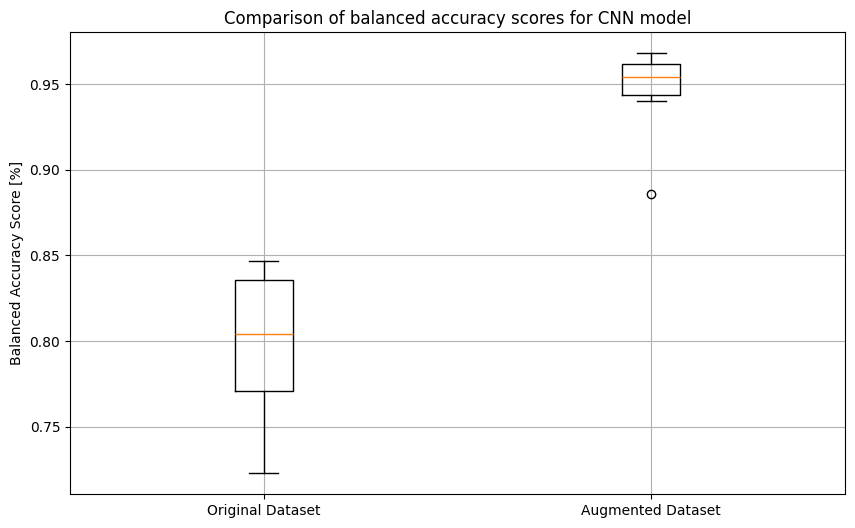

Original Dataset: Mean = 0.7989, Std = 0.0386
Augmented Dataset: Mean = 0.9480, Std = 0.0227


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


augmented_scores = []
model = keras.models.load_model("data/models/CNN_LAST.keras")
for i in range(10):
    # Split the dataset
    train_X, test_X, train_y, test_y = train_test_split(X_aug, y_aug_encoded, test_size=0.2, random_state=None)
    
    # Reshape the input data to match the expected input shape of the CNN
    train_X = train_X.reshape((-1, 20, 20, 1))
    test_X = test_X.reshape((-1, 20, 20, 1))
    
    # Train the model
    model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
    
    # Make predictions
    y_pred = model.predict(test_X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Evaluate using balanced accuracy score
    score = balanced_accuracy_score(test_y, y_pred_classes)
    augmented_scores.append(score)
augmented_scores = [94.04,96.8,95.2,95.6,96.4,96.8,95.6,94.2,94.8,88.6]
for i in range(len(augmented_scores)):
    augmented_scores[i] = augmented_scores[i]/100

# Create box plots to compare the results
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of balanced accuracy scores for CNN model")
plt.ylabel("Balanced Accuracy Score [%]")
plt.grid(True)
with PdfPages('balanced_accuracy_scores_comparison.pdf') as pdf:
    pdf.savefig()  # saves the current figure
plt.show()

# Save the plot to a PDF file
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")